In [2]:
!pip install ipython-autotime
%load_ext autotime

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
time: 603 µs (started: 2021-05-12 00:51:24 +00:00)


In [3]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from keras.layers import Input,Dense,Conv2D,MaxPooling2D,UpSampling2D
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.optimizers import RMSprop

time: 6.05 s (started: 2021-05-12 00:51:24 +00:00)


In [4]:
def load_data(no_of_images):
    
    img_size = (256,256)
    imgs_source = []
    imgs_target = []
    
    dir_source = "../input/xray-bone-shadow-supression/augmented/augmented/source"
    dir_target = "../input/xray-bone-shadow-supression/augmented/augmented/target"
    
    i = 0
    for _, _, filenames in os.walk('/kaggle/input/xray-bone-shadow-supression/augmented/augmented/source/'):
        for filename in filenames:
            i = i+1
            if(i > no_of_images):
                break
            img_source = cv2.imread(os.path.join(dir_source,filename),cv2.IMREAD_GRAYSCALE)
            img_target = cv2.imread(os.path.join(dir_target, filename),cv2.IMREAD_GRAYSCALE)
            # resizing images
            img_source = cv2.resize(img_source,img_size)
            img_target = cv2.resize(img_target,img_size)
            # normalizing images
            img_source = np.array(img_source)/255
            img_target = np.array(img_target)/255
            
            imgs_source.append(img_source)
            imgs_target.append(img_target)
    return imgs_source, imgs_target

time: 802 µs (started: 2021-05-12 00:51:30 +00:00)


In [5]:
source, target = load_data(1000)

time: 53.1 s (started: 2021-05-12 00:51:30 +00:00)


In [6]:
print(source[1].shape)

(256, 256)
time: 1.46 ms (started: 2021-05-12 00:52:23 +00:00)


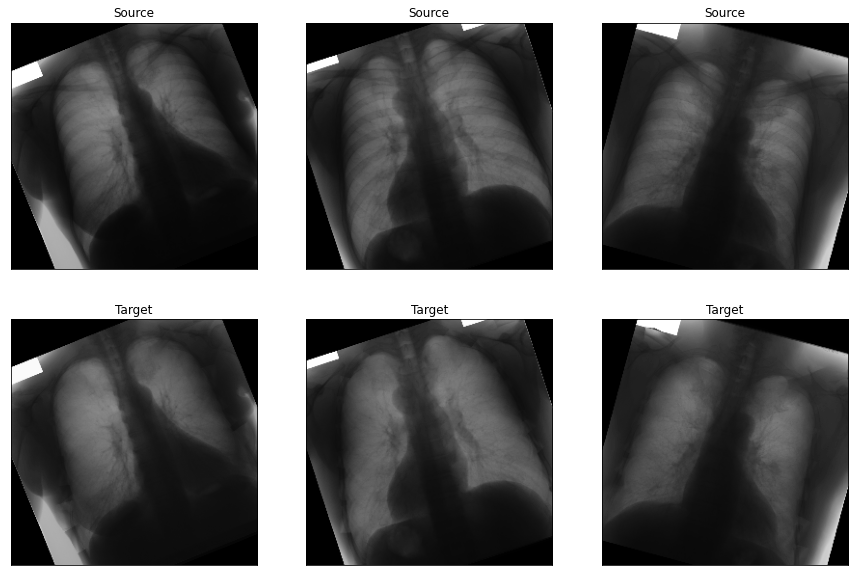

time: 591 ms (started: 2021-05-12 00:52:23 +00:00)


In [7]:
plt.figure(figsize=(15,10))

for i in range(3):
    ax = plt.subplot(2, 3, i+1)
    plt.imshow(source[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title('Source')

    ax = plt.subplot(2, 3, i+4)
    plt.imshow(target[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title('Target')
plt.show()

In [8]:
img_rows = 256
img_cols = 256
img_channels = 1
img_shape = (img_rows, img_cols, img_channels)
source = np.array(source).reshape(-1, img_rows, img_cols, img_channels)
target = np.array(target).reshape(-1, img_rows, img_cols, img_channels)

source_train, source_test, target_train, target_test = train_test_split(source, target,
                                                                        test_size=0.20,
                                                                        random_state=1)

time: 533 ms (started: 2021-05-12 00:52:24 +00:00)


In [9]:
print(source_train.shape, source_test.shape, target_train.shape, target_test.shape)

(800, 256, 256, 1) (200, 256, 256, 1) (800, 256, 256, 1) (200, 256, 256, 1)
time: 1.85 ms (started: 2021-05-12 00:52:24 +00:00)


In [10]:
def autoencoder(input_img):
    #encoder
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) 
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2), padding='same')(conv1) 
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) 
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2), padding='same')(conv2) 
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2) 
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)


    #decoder
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv3) 
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    up1 = UpSampling2D((2,2))(conv4) 
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1) 
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    up2 = UpSampling2D((2,2))(conv5) 
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2) 
    return decoded

time: 1.27 ms (started: 2021-05-12 00:52:24 +00:00)


In [11]:
input_img = Input(shape = img_shape)
autoencoder = Model(input_img, autoencoder(input_img))
autoencoder.compile(loss='mean_squared_error', optimizer = "adam")

time: 2.65 s (started: 2021-05-12 00:52:24 +00:00)


In [12]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 32)      320       
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 256, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 32)      9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 256, 256, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 64)      18496 

In [13]:
n_epoch = 2000
n_batch = 128
autoencoder_train = autoencoder.fit(source_train, target_train,
                                    epochs = n_epoch,
                                    batch_size = n_batch,
                                    verbose = 0,
                                    validation_data = (source_test, target_test))

time: 2h 32min 15s (started: 2021-05-12 00:52:27 +00:00)


In [14]:
interval_epochs = [0, 49,99,149,199,249,299,349,399,449,499,599,1099,1599,1699,1899,1949,1999]
for e in interval_epochs:
    print("epoch = {}\tLoss = {:.5f}\tValidation_Loss = {:.5f}".format(e+1,autoencoder_train.history['loss'][e],autoencoder_train.history['val_loss'][e]))

epoch = 1	Loss = 0.09468	Validation_Loss = 0.09601
epoch = 50	Loss = 0.00152	Validation_Loss = 0.01906
epoch = 100	Loss = 0.00138	Validation_Loss = 0.14621
epoch = 150	Loss = 0.00167	Validation_Loss = 0.22150
epoch = 200	Loss = 0.00125	Validation_Loss = 0.00129
epoch = 250	Loss = 0.00121	Validation_Loss = 0.00111
epoch = 300	Loss = 0.00106	Validation_Loss = 0.00100
epoch = 350	Loss = 0.00101	Validation_Loss = 0.00093
epoch = 400	Loss = 0.00095	Validation_Loss = 0.00088
epoch = 450	Loss = 0.00096	Validation_Loss = 0.00335
epoch = 500	Loss = 0.00095	Validation_Loss = 0.00093
epoch = 600	Loss = 0.00183	Validation_Loss = 0.13637
epoch = 1100	Loss = 0.00080	Validation_Loss = 0.00074
epoch = 1600	Loss = 0.00069	Validation_Loss = 0.00075
epoch = 1700	Loss = 0.00080	Validation_Loss = 0.00080
epoch = 1900	Loss = 0.00068	Validation_Loss = 0.00070
epoch = 1950	Loss = 0.00080	Validation_Loss = 0.00266
epoch = 2000	Loss = 0.00073	Validation_Loss = 0.00069
time: 2.9 ms (started: 2021-05-12 03:24:42 

(200, 256, 256, 1)


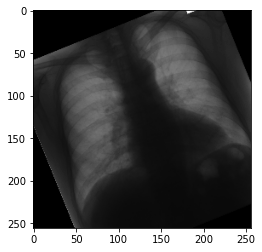

200
(256, 256, 1)


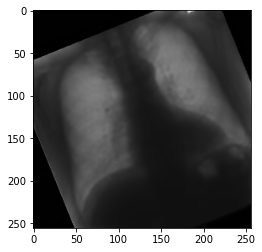

time: 1.12 s (started: 2021-05-12 03:24:42 +00:00)


In [15]:
pred = autoencoder.predict(source_test)
print(source_test.shape)
plt.imshow(source_test[1])
plt.show()
print(len(pred))
print(pred[1].shape)
plt.imshow(pred[1])
plt.show()

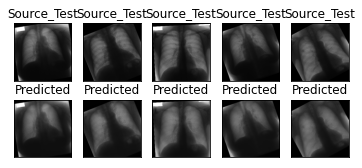

time: 511 ms (started: 2021-05-12 03:24:44 +00:00)


In [16]:
#plt.figure(figsize=(15,10))

for i in range(5):
    ax = plt.subplot(3, 5, i+1)
    plt.imshow(source_test[i].reshape(256,256))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title('Source_Test')

    ax = plt.subplot(3, 5, i+6)
    plt.imshow(pred[i].reshape(256,256))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title('Predicted')
    
    '''ax = plt.subplot(3, 5, i+11)
    plt.imshow(target_test[i].reshape(128,128))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title('Target')'''
plt.show()

In [17]:
autoencoder.save("2000bs256.h5")

time: 172 ms (started: 2021-05-12 03:24:44 +00:00)


In [101]:
!pip install imutils

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
time: 5.93 s (started: 2021-05-11 18:46:39 +00:00)


(1024, 1024)
(128, 128)
(128, 128, 1)
(1, 128, 128, 1)
(128, 128, 1)
1
(1, 128, 128, 1)


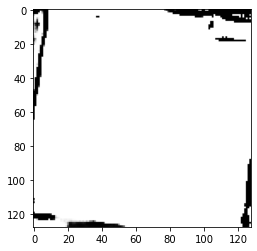

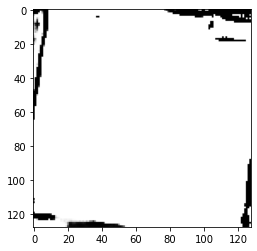

time: 321 ms (started: 2021-05-11 18:01:19 +00:00)


In [84]:
import imutils
import tensorflow as tf
img_rows = 128
img_cols = 128
img_channels = 1
img_shape = (img_rows, img_cols, img_channels)

image=cv2.imread("../input/xray-bone-shadow-supression/augmented/augmented/source/0_101.png",0)
print(image.shape)
image=imutils.resize(image,128)
print(image.shape)
img_rows = 128
img_cols = 128
img_channels = 1
img_shape = (img_rows, img_cols, img_channels)
image = np.array(image).reshape(img_rows, img_cols, img_channels)
print(image.shape)
image=np.expand_dims(image,-4)
print(image.shape)
print(image[0].shape)
print(len(image))
#autoencoder = tf.keras.models.load_model("./bonesupression.h5")
pred = autoencoder.predict(image)
print(pred.shape)
#print(pred.shape)
plt.imshow(pred[0].reshape(128,128))
plt.show()
#pred = pred[0,:, :,:]
#print(pred[0].shape)
#pred=transform.resize(pred,(128,128,1))

'''if len(pred.shape) == 4:
    #convert the image from RGBA2RGB
    pred = cv2.cvtColor(pred, cv2.COLOR_BGRA2BGR)
print(pred.shape)'''
predic=pred[0].reshape(128,128)
plt.imsave("hey.png",pred[0].reshape(128,128))
plt.imshow(pred[0].reshape(128,128))
plt.show()